In [1]:
import os
# in puhti.csc.fi some of the python packages are installed under user's folder, make sure the correct 
# folder is included in the path

import sys
sys.path.append('/users/vesalaia/.local/lib/python3.9/site-packages')
sys.path.append('/users/vesalaia/.local/lib/python3.9/site-packages/bin')
sys.path.append('/users/vesalaia/.local/lib/python3.9/site-packages/lib/python3.9/site-packages')

In [2]:
# detectron2 is used for object detection

import detectron2


In [3]:
detectron2.__version__

'0.6'

In [4]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor

from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog
from detectron2.utils.visualizer import ColorMode

In [5]:
from detectron2.structures import BoxMode

In [6]:
# some other key libraries

import torch

from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt




### Data setup

In [7]:
from detectron2.data.datasets import register_coco_instances
from pycocotools.coco import COCO

register_coco_instances("Illustrations", {}, 
                        "/scratch/project_2005488/DHH23/bbox/result.json", 
                        "/scratch/project_2005488/DHH23/bbox")

In [10]:
sys.path.append('/users/vesalaia/cocoapi/PythonAPI/pycocotools')
sys.path.append('/users/vesalaia/vision/references/detection')

In [11]:
TRAIN_RATIO = 0.9

In [12]:
# some conversions between PIL and cv2 images

def convert_from_cv2_to_image(img: np.ndarray) -> Image:
    # return Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return Image.fromarray(img)


def convert_from_image_to_cv2(img: Image) -> np.ndarray:
    # return cv2.cvtColor(numpy.array(img), cv2.COLOR_RGB2BGR)
    return np.asarray(img)

In [21]:
# description of element classes from PubLayNet we use for transfer learning

Elementclasses = {'Text':0, "Title":1, "List":2, "Table":3, "Figure":4}
UNKNOWN = len(Elementclasses)-1

ElementclassLabels = [x for x in Elementclasses.keys()]
reverse_Elementclass = {v:k for k,v in Elementclasses.items()}
def get_key(l):
    return reverse_Elementclass[l]

In [22]:
len(DatasetCatalog.get("Illustrations"))

WARNING [05/19 09:42:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/19 09:42:47 d2.data.datasets.coco]: Loaded 500 images in COCO format from /scratch/project_2005488/DHH23/bbox/result.json


500

In [23]:
metadata = MetadataCatalog.get("Illustrations")

In [24]:
metadata

namespace(name='Illustrations',
          json_file='/scratch/project_2005488/DHH23/bbox/result.json',
          image_root='/scratch/project_2005488/DHH23/bbox',
          evaluator_type='coco',
          thing_classes=['Text', 'Title', 'List', 'Table', 'Figure'],
          thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2, 3: 3, 4: 4})

In [25]:
from detectron2.utils.visualizer import ColorMode

import random
import cv2
import matplotlib.pyplot as plt

def plot_samples(dataset_name, n=1):
    dataset_custom = DatasetCatalog.get(dataset_name)
    dataset_custom_metadata = MetadataCatalog.get(dataset_name)
   
    for s in random.sample(list(dataset_custom), n):
        print(s['file_name'], s['image_id'])
        img = cv2.imread(s['file_name'])
        v = Visualizer(img[:,:,::-1], metadata=dataset_custom_metadata, scale=0.5)
        v = v.draw_dataset_dict(s)
        plt.figure(figsize=(15,20))
        plt.imshow(v.get_image())
        plt.show()

### Training

In [26]:
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

WARNING [05/19 09:43:04 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/19 09:43:04 d2.data.datasets.coco]: Loaded 500 images in COCO format from /scratch/project_2005488/DHH23/bbox/result.json
/scratch/project_2005488/DHH23/bbox/images/a87bb0d7-002940100000160.png 23


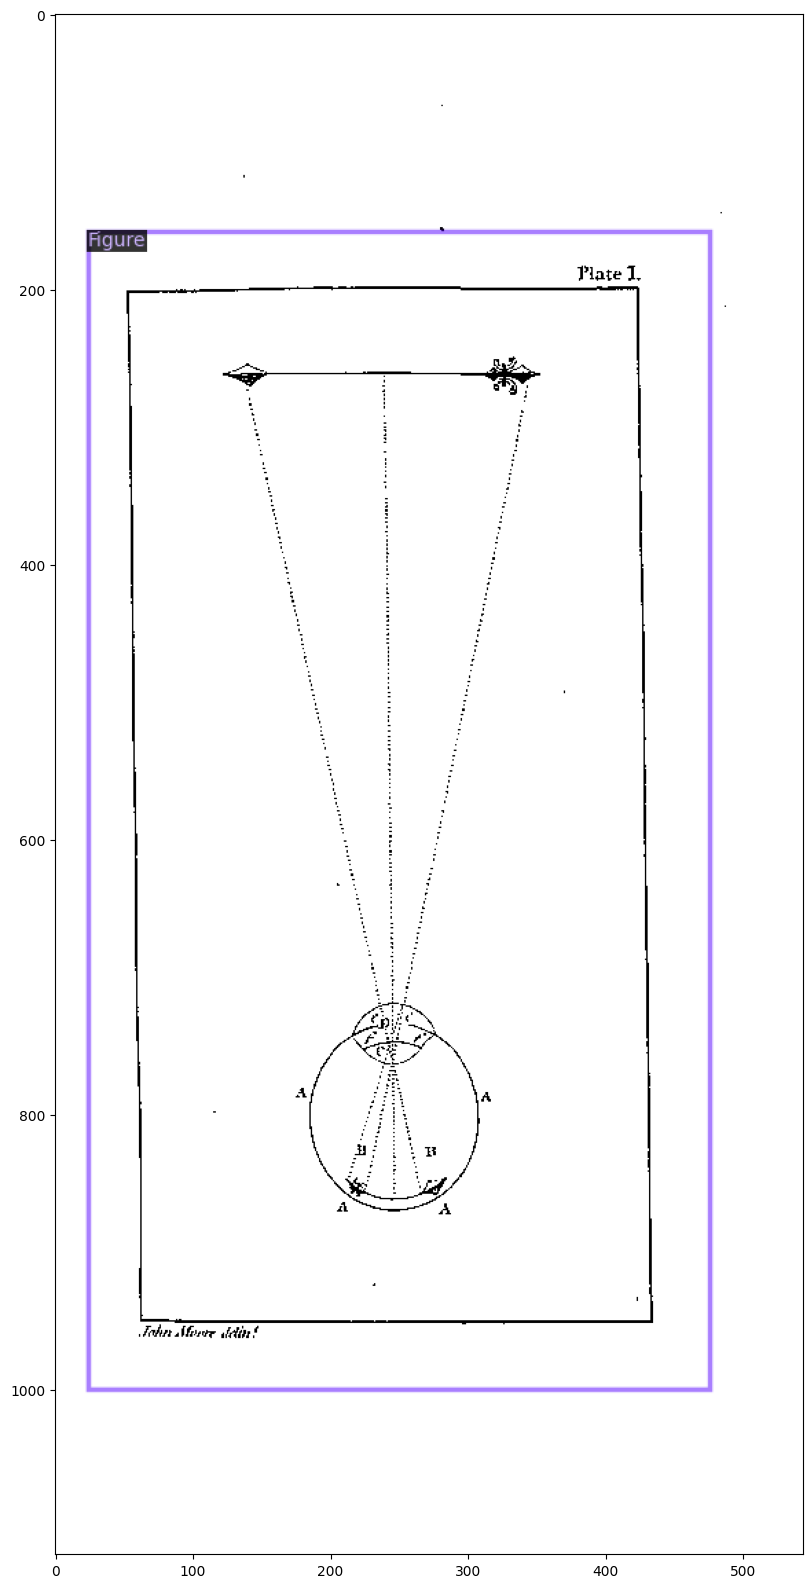

/scratch/project_2005488/DHH23/bbox/images/9790f0c3-016530070001720.png 345


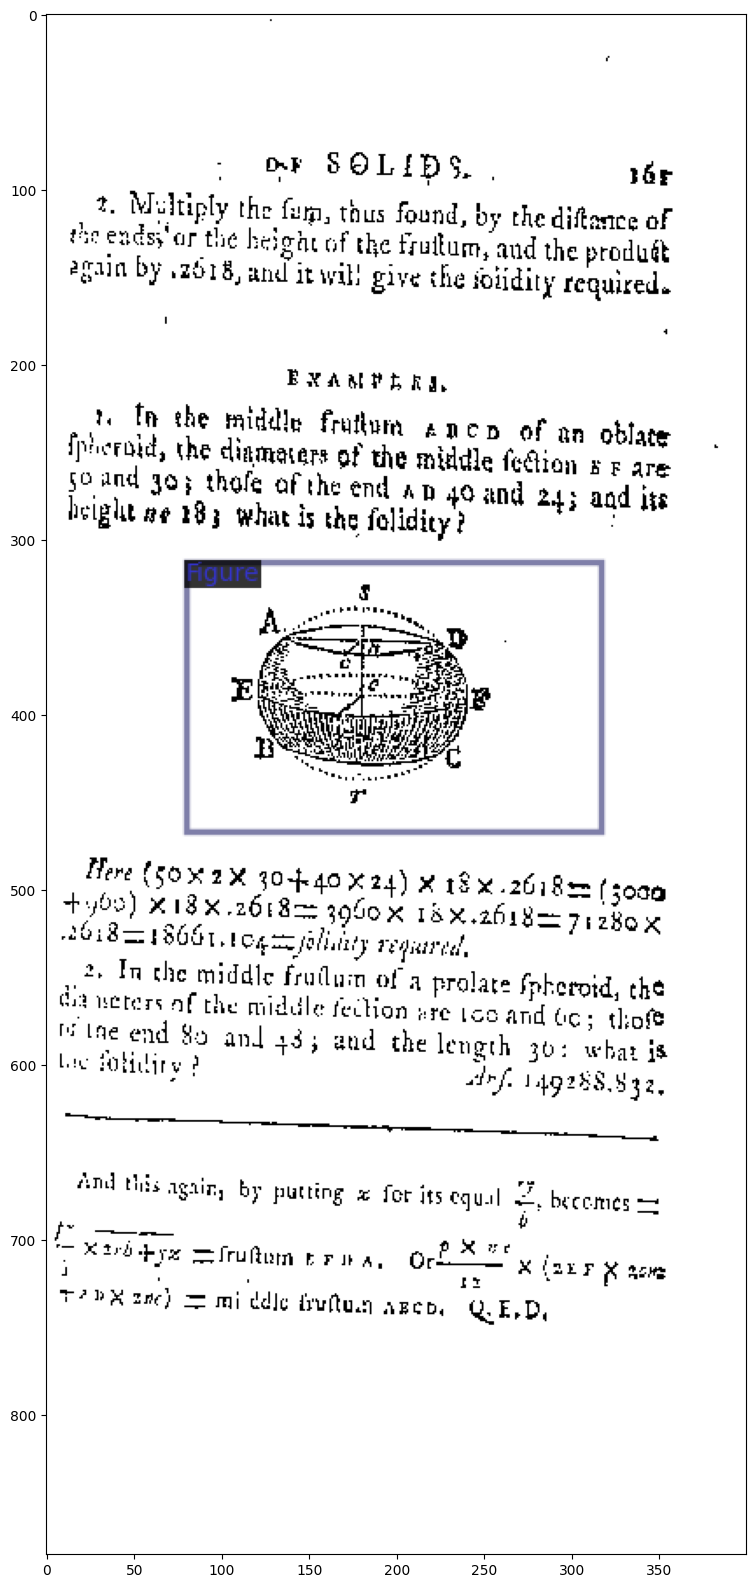

/scratch/project_2005488/DHH23/bbox/images/2b8b931c-128440030002630.png 134


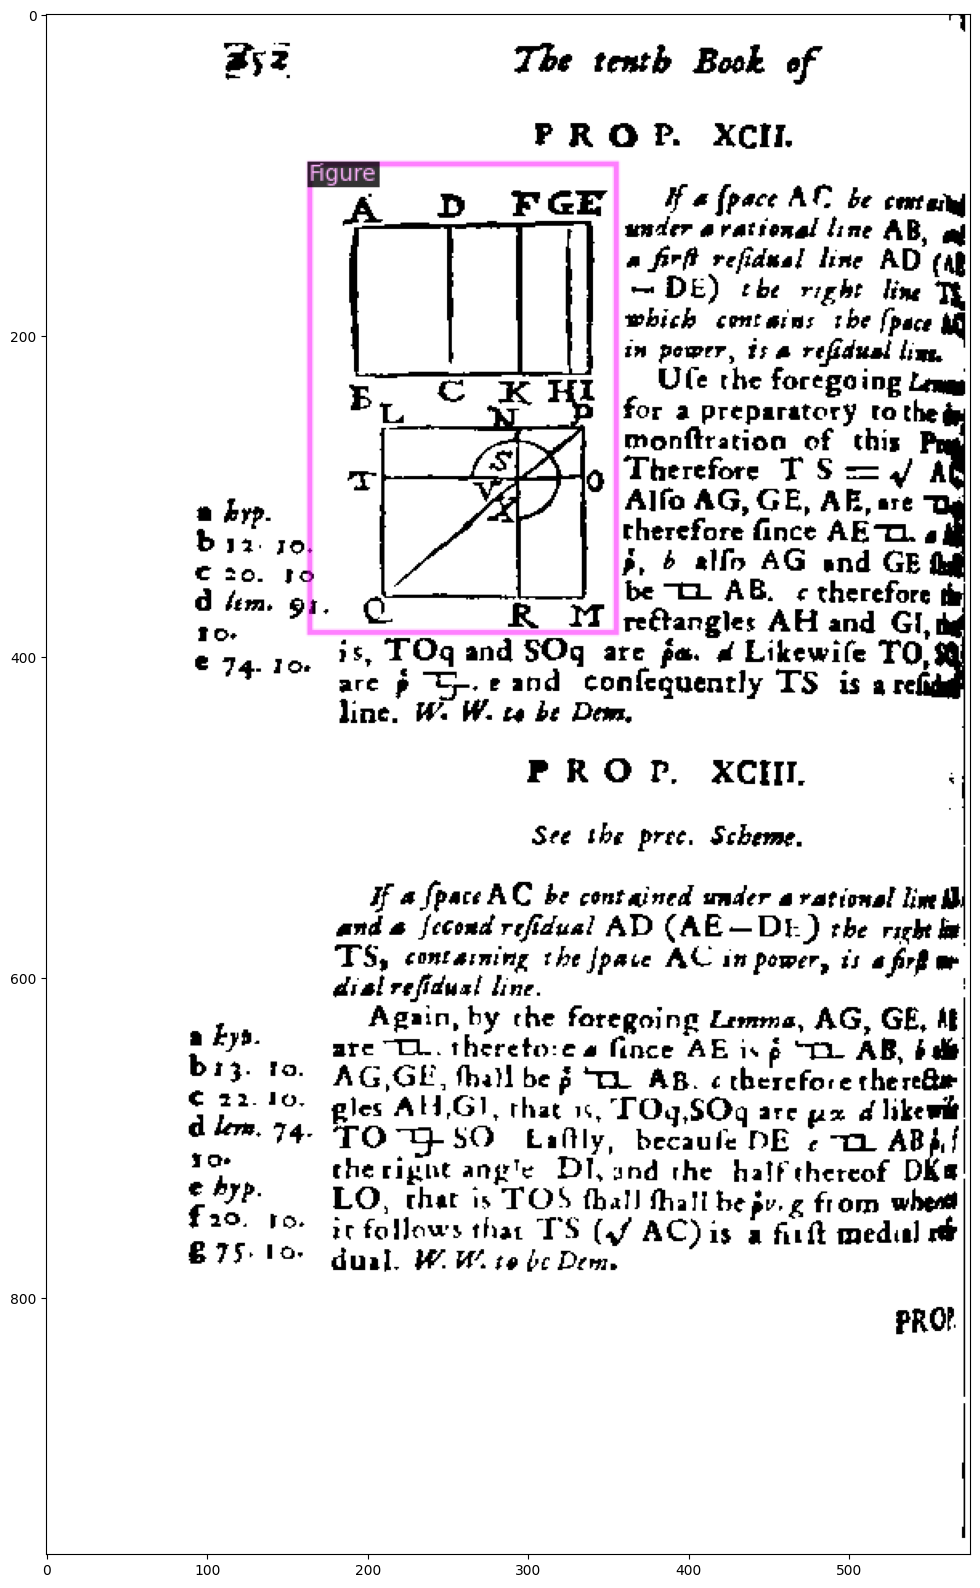

/scratch/project_2005488/DHH23/bbox/images/5cf9985c-016530070001190.png 342


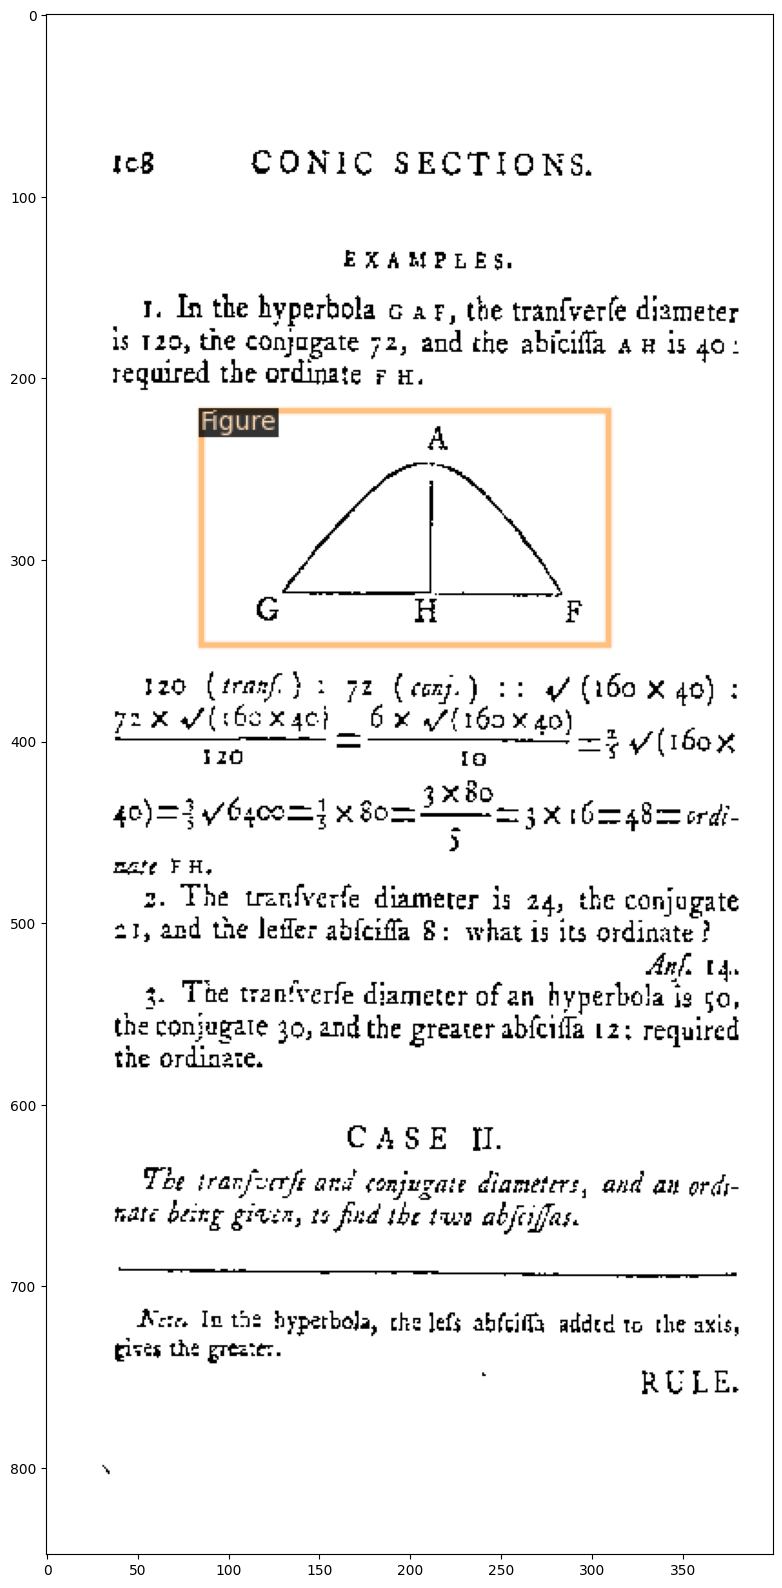

/scratch/project_2005488/DHH23/bbox/images/03599a2a-035010100003670.png 283


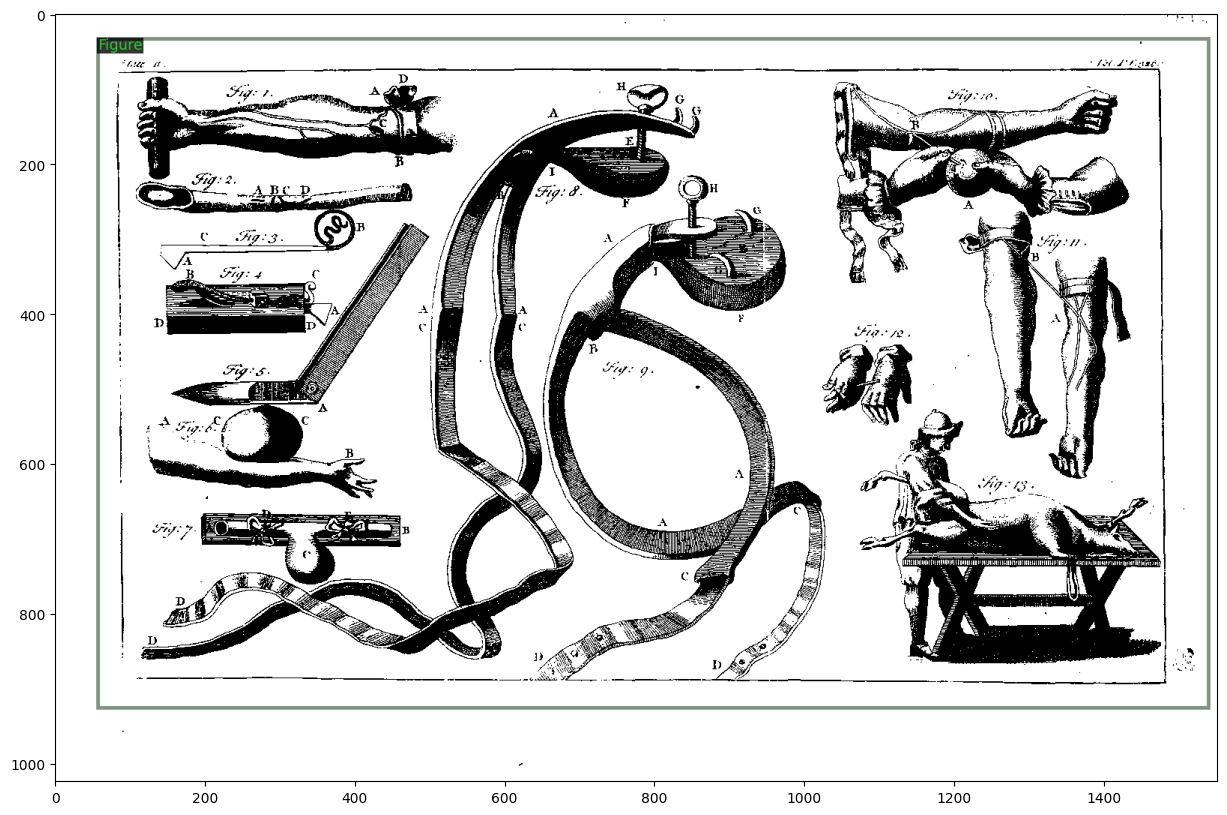

In [27]:
plot_samples("Illustrations",n=5)


In [25]:

from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
import copy

def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
        T.Resize((800,600)),
        T.RandomBrightness(0.8, 1.8),
        T.RandomContrast(0.6, 1.3),
        T.RandomSaturation(0.8, 1.4),
        T.RandomLighting(0.7),
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

In [26]:
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_test_loader, build_detection_train_loader

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

In [28]:


config_file_path = "/scratch/project_2005488/DHH23/config.yaml"

train_dataset_name = "Illustrations"
num_classes = len(ElementclassLabels)
device = "cuda"
output_dir = "/scratch/project_2005488/DHH23/model"

def get_train_cfg(config_file_path, train_dataset_name, num_classes, device, output_dir):

    
    cfg = get_cfg()
    cfg.merge_from_file(config_file_path)
    cfg.MODEL.WEIGHTS = "/scratch/project_2005488/DHH23/model_final.pth"
    cfg.DATASETS.TRAIN = (train_dataset_name,)

    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.001
    cfg.SOLVER.MAX_ITER = 20000
    cfg.SOLVER.STEPS = []
    
#    cfg.TEST.EVAL_PERIOD = 100
    cfg.DETECTIONS_PER_IMAGE = 100

    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
    cfg.MODEL.DEVICE = device
    cfg.OUTPUT_DIR = output_dir
    cfg.MASK_FORMAT = "bitmask"
    return cfg

In [29]:
cfg = get_train_cfg(config_file_path, train_dataset_name,  num_classes, device, output_dir)

In [30]:
num_classes

5

In [31]:
print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('PubLayNet-val',)
  TRAIN: ('Illustrations',)
DETECTIONS_PER_IMAGE: 100
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MASK_FORMAT: bitmask
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:


In [31]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
from detectron2.evaluation import COCOEvaluator
import detectron2.data.transforms as T
import copy

def custom_mapper(dataset_dict):
    
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [T.Resize((800,800)),
                      T.RandomBrightness(0.9, 1.1)]
            
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict
class AugTrainer(DefaultTrainer):
    
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)



In [32]:
trainer = CustomTrainer(cfg)

[05/17 18:51:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

WARNING [05/17 18:51:15 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/17 18:51:15 d2.data.datasets.coco]: Loaded 500 images in COCO format from /scratch/project_2005488/DHH23/bbox/result.json
[05/17 18:51:15 d2.data.build]: Removed 0 images with no usable annotations. 500 images left.
[05/17 18:51:15 d2.data.build]: Distribution of instances among all 5 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    Text    | 0            |   Title    | 0            |    List    | 0            |
|   Table    | 0            |   Figure   | 623          |            |              |
|   total    | 623          |            |              |            |              |
[05/17 18:51:15 d2.data.build]: Using training sampler TrainingSampler
[05/17 18:51:15 d2.data.common]: Serializing the dataset us

In [33]:
#trainer = DefaultTrainer(cfg)
#trainer = AugTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[05/17 18:51:32 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /scratch/project_2005488/DHH23/model_final.pth ...


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (7, 1024) in the checkpoint but (6, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (7,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (24, 1024) in the checkpoint but (20, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (24,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weig

[05/17 18:51:33 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib64/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/17 18:51:39 d2.utils.events]:  eta: 0:43:45  iter: 19  total_loss: 2.009  loss_cls: 1.738  loss_box_reg: 0.1979  loss_rpn_cls: 0.02515  loss_rpn_loc: 0.02246  time: 0.1373  data_time: 0.0457  lr: 1.9981e-05  max_mem: 1739M
[05/17 18:51:42 d2.utils.events]:  eta: 0:43:35  iter: 39  total_loss: 0.691  loss_cls: 0.3484  loss_box_reg: 0.2152  loss_rpn_cls: 0.03433  loss_rpn_loc: 0.02128  time: 0.1417  data_time: 0.0188  lr: 3.9961e-05  max_mem: 1739M
[05/17 18:51:45 d2.utils.events]:  eta: 0:43:34  iter: 59  total_loss: 0.383  loss_cls: 0.1618  loss_box_reg: 0.1536  loss_rpn_cls: 0.02054  loss_rpn_loc: 0.01383  time: 0.1410  data_time: 0.0139  lr: 5.9941e-05  max_mem: 1739M
[05/17 18:51:48 d2.utils.events]:  eta: 0:43:31  iter: 79  total_loss: 0.3992  loss_cls: 0.1739  loss_box_reg: 0.1921  loss_rpn_cls: 0.01154  loss_rpn_loc: 0.0192  time: 0.1431  data_time: 0.0228  lr: 7.9921e-05  max_mem: 1739M
[05/17 18:51:51 d2.utils.events]:  eta: 0:43:32  iter: 99  total_loss: 0.4237  loss_cls: 

[05/17 18:53:19 d2.utils.events]:  eta: 0:43:07  iter: 699  total_loss: 0.1449  loss_cls: 0.03156  loss_box_reg: 0.08197  loss_rpn_cls: 0.0007479  loss_rpn_loc: 0.008664  time: 0.1382  data_time: 0.0079  lr: 0.0006993  max_mem: 1739M
[05/17 18:53:22 d2.utils.events]:  eta: 0:43:05  iter: 719  total_loss: 0.1413  loss_cls: 0.04846  loss_box_reg: 0.08421  loss_rpn_cls: 0.001082  loss_rpn_loc: 0.007708  time: 0.1382  data_time: 0.0099  lr: 0.00071928  max_mem: 1739M
[05/17 18:53:24 d2.utils.events]:  eta: 0:43:03  iter: 739  total_loss: 0.1262  loss_cls: 0.03407  loss_box_reg: 0.08365  loss_rpn_cls: 0.001151  loss_rpn_loc: 0.005092  time: 0.1382  data_time: 0.0065  lr: 0.00073926  max_mem: 1739M
[05/17 18:53:27 d2.utils.events]:  eta: 0:43:04  iter: 759  total_loss: 0.1062  loss_cls: 0.02297  loss_box_reg: 0.07281  loss_rpn_cls: 0.000635  loss_rpn_loc: 0.006992  time: 0.1383  data_time: 0.0128  lr: 0.00075924  max_mem: 1739M
[05/17 18:53:30 d2.utils.events]:  eta: 0:43:02  iter: 779  tota

[05/17 18:54:56 d2.utils.events]:  eta: 0:41:48  iter: 1379  total_loss: 0.06827  loss_cls: 0.01895  loss_box_reg: 0.04034  loss_rpn_cls: 0.0003104  loss_rpn_loc: 0.005115  time: 0.1378  data_time: 0.0053  lr: 0.001  max_mem: 1739M
[05/17 18:54:59 d2.utils.events]:  eta: 0:41:45  iter: 1399  total_loss: 0.08202  loss_cls: 0.01682  loss_box_reg: 0.05875  loss_rpn_cls: 0.0001492  loss_rpn_loc: 0.003609  time: 0.1379  data_time: 0.0154  lr: 0.001  max_mem: 1739M
[05/17 18:55:02 d2.utils.events]:  eta: 0:41:43  iter: 1419  total_loss: 0.0917  loss_cls: 0.01607  loss_box_reg: 0.06068  loss_rpn_cls: 0.0002206  loss_rpn_loc: 0.004397  time: 0.1378  data_time: 0.0041  lr: 0.001  max_mem: 1739M
[05/17 18:55:04 d2.utils.events]:  eta: 0:41:40  iter: 1439  total_loss: 0.09322  loss_cls: 0.01637  loss_box_reg: 0.07002  loss_rpn_cls: 0.0003984  loss_rpn_loc: 0.004706  time: 0.1378  data_time: 0.0056  lr: 0.001  max_mem: 1739M
[05/17 18:55:07 d2.utils.events]:  eta: 0:41:36  iter: 1459  total_loss: 

[05/17 18:56:32 d2.utils.events]:  eta: 0:40:12  iter: 2079  total_loss: 0.05901  loss_cls: 0.01403  loss_box_reg: 0.04166  loss_rpn_cls: 0.0001348  loss_rpn_loc: 0.005926  time: 0.1375  data_time: 0.0053  lr: 0.001  max_mem: 1739M
[05/17 18:56:35 d2.utils.events]:  eta: 0:40:09  iter: 2099  total_loss: 0.07119  loss_cls: 0.01359  loss_box_reg: 0.04519  loss_rpn_cls: 0.0001162  loss_rpn_loc: 0.00451  time: 0.1375  data_time: 0.0062  lr: 0.001  max_mem: 1739M
[05/17 18:56:38 d2.utils.events]:  eta: 0:40:07  iter: 2119  total_loss: 0.06378  loss_cls: 0.01244  loss_box_reg: 0.04869  loss_rpn_cls: 0.0001827  loss_rpn_loc: 0.003895  time: 0.1375  data_time: 0.0127  lr: 0.001  max_mem: 1739M
[05/17 18:56:41 d2.utils.events]:  eta: 0:40:04  iter: 2139  total_loss: 0.08303  loss_cls: 0.01854  loss_box_reg: 0.06526  loss_rpn_cls: 0.0001019  loss_rpn_loc: 0.003508  time: 0.1375  data_time: 0.0041  lr: 0.001  max_mem: 1739M
[05/17 18:56:44 d2.utils.events]:  eta: 0:40:01  iter: 2159  total_loss: 

[05/17 18:58:09 d2.utils.events]:  eta: 0:38:37  iter: 2779  total_loss: 0.04999  loss_cls: 0.01117  loss_box_reg: 0.03453  loss_rpn_cls: 0.0002545  loss_rpn_loc: 0.004762  time: 0.1375  data_time: 0.0040  lr: 0.001  max_mem: 1739M
[05/17 18:58:12 d2.utils.events]:  eta: 0:38:35  iter: 2799  total_loss: 0.06147  loss_cls: 0.01474  loss_box_reg: 0.03951  loss_rpn_cls: 0.0001061  loss_rpn_loc: 0.005408  time: 0.1375  data_time: 0.0104  lr: 0.001  max_mem: 1739M
[05/17 18:58:15 d2.utils.events]:  eta: 0:38:31  iter: 2819  total_loss: 0.05613  loss_cls: 0.01442  loss_box_reg: 0.03634  loss_rpn_cls: 8.396e-05  loss_rpn_loc: 0.003345  time: 0.1375  data_time: 0.0040  lr: 0.001  max_mem: 1739M
[05/17 18:58:17 d2.utils.events]:  eta: 0:38:29  iter: 2839  total_loss: 0.0684  loss_cls: 0.01394  loss_box_reg: 0.04784  loss_rpn_cls: 0.0001633  loss_rpn_loc: 0.004114  time: 0.1375  data_time: 0.0062  lr: 0.001  max_mem: 1739M
[05/17 18:58:20 d2.utils.events]:  eta: 0:38:26  iter: 2859  total_loss: 

[05/17 18:59:46 d2.utils.events]:  eta: 0:37:01  iter: 3479  total_loss: 0.0569  loss_cls: 0.01263  loss_box_reg: 0.03993  loss_rpn_cls: 0.0001786  loss_rpn_loc: 0.003492  time: 0.1375  data_time: 0.0064  lr: 0.001  max_mem: 1739M
[05/17 18:59:49 d2.utils.events]:  eta: 0:36:58  iter: 3499  total_loss: 0.06034  loss_cls: 0.01054  loss_box_reg: 0.04228  loss_rpn_cls: 0.0001095  loss_rpn_loc: 0.003576  time: 0.1375  data_time: 0.0045  lr: 0.001  max_mem: 1739M
[05/17 18:59:51 d2.utils.events]:  eta: 0:36:55  iter: 3519  total_loss: 0.05302  loss_cls: 0.01147  loss_box_reg: 0.03711  loss_rpn_cls: 0.0001237  loss_rpn_loc: 0.004145  time: 0.1375  data_time: 0.0061  lr: 0.001  max_mem: 1739M
[05/17 18:59:54 d2.utils.events]:  eta: 0:36:53  iter: 3539  total_loss: 0.05287  loss_cls: 0.01049  loss_box_reg: 0.03634  loss_rpn_cls: 0.0001516  loss_rpn_loc: 0.00546  time: 0.1375  data_time: 0.0153  lr: 0.001  max_mem: 1739M
[05/17 18:59:57 d2.utils.events]:  eta: 0:36:50  iter: 3559  total_loss: 0

[05/17 19:01:22 d2.utils.events]:  eta: 0:35:26  iter: 4179  total_loss: 0.05523  loss_cls: 0.01149  loss_box_reg: 0.037  loss_rpn_cls: 9.123e-05  loss_rpn_loc: 0.003011  time: 0.1373  data_time: 0.0057  lr: 0.001  max_mem: 1739M
[05/17 19:01:24 d2.utils.events]:  eta: 0:35:23  iter: 4199  total_loss: 0.05067  loss_cls: 0.01279  loss_box_reg: 0.02996  loss_rpn_cls: 0.0001118  loss_rpn_loc: 0.004915  time: 0.1373  data_time: 0.0053  lr: 0.001  max_mem: 1739M
[05/17 19:01:27 d2.utils.events]:  eta: 0:35:20  iter: 4219  total_loss: 0.05198  loss_cls: 0.009788  loss_box_reg: 0.03426  loss_rpn_cls: 0.0001183  loss_rpn_loc: 0.003626  time: 0.1373  data_time: 0.0052  lr: 0.001  max_mem: 1739M
[05/17 19:01:30 d2.utils.events]:  eta: 0:35:17  iter: 4239  total_loss: 0.04451  loss_cls: 0.01258  loss_box_reg: 0.02852  loss_rpn_cls: 7.341e-05  loss_rpn_loc: 0.00363  time: 0.1373  data_time: 0.0082  lr: 0.001  max_mem: 1739M
[05/17 19:01:33 d2.utils.events]:  eta: 0:35:15  iter: 4259  total_loss: 0

[05/17 19:02:55 d2.utils.events]:  eta: 0:33:53  iter: 4859  total_loss: 0.03915  loss_cls: 0.008943  loss_box_reg: 0.02781  loss_rpn_cls: 0.0001925  loss_rpn_loc: 0.004057  time: 0.1372  data_time: 0.0106  lr: 0.001  max_mem: 1739M
[05/17 19:02:58 d2.utils.events]:  eta: 0:33:50  iter: 4879  total_loss: 0.05898  loss_cls: 0.01089  loss_box_reg: 0.04325  loss_rpn_cls: 8.498e-05  loss_rpn_loc: 0.00336  time: 0.1372  data_time: 0.0050  lr: 0.001  max_mem: 1739M
[05/17 19:03:01 d2.utils.events]:  eta: 0:33:48  iter: 4899  total_loss: 0.05142  loss_cls: 0.009393  loss_box_reg: 0.03639  loss_rpn_cls: 0.0001812  loss_rpn_loc: 0.004088  time: 0.1372  data_time: 0.0209  lr: 0.001  max_mem: 1739M
[05/17 19:03:03 d2.utils.events]:  eta: 0:33:45  iter: 4919  total_loss: 0.04615  loss_cls: 0.01157  loss_box_reg: 0.0305  loss_rpn_cls: 0.0001058  loss_rpn_loc: 0.00286  time: 0.1372  data_time: 0.0046  lr: 0.001  max_mem: 1739M
[05/17 19:03:06 d2.utils.events]:  eta: 0:33:43  iter: 4939  total_loss: 

[05/17 19:04:33 d2.utils.events]:  eta: 0:32:20  iter: 5559  total_loss: 0.03819  loss_cls: 0.009773  loss_box_reg: 0.02506  loss_rpn_cls: 0.0001255  loss_rpn_loc: 0.002609  time: 0.1372  data_time: 0.0058  lr: 0.001  max_mem: 1739M
[05/17 19:04:36 d2.utils.events]:  eta: 0:32:17  iter: 5579  total_loss: 0.03315  loss_cls: 0.007323  loss_box_reg: 0.02247  loss_rpn_cls: 0.0001123  loss_rpn_loc: 0.003512  time: 0.1372  data_time: 0.0082  lr: 0.001  max_mem: 1739M
[05/17 19:04:39 d2.utils.events]:  eta: 0:32:15  iter: 5599  total_loss: 0.03768  loss_cls: 0.01018  loss_box_reg: 0.02307  loss_rpn_cls: 8.086e-05  loss_rpn_loc: 0.00323  time: 0.1372  data_time: 0.0049  lr: 0.001  max_mem: 1739M
[05/17 19:04:42 d2.utils.events]:  eta: 0:32:12  iter: 5619  total_loss: 0.03495  loss_cls: 0.006846  loss_box_reg: 0.02341  loss_rpn_cls: 5.263e-05  loss_rpn_loc: 0.003381  time: 0.1372  data_time: 0.0064  lr: 0.001  max_mem: 1739M
[05/17 19:04:44 d2.utils.events]:  eta: 0:32:10  iter: 5639  total_los

[05/17 19:06:08 d2.utils.events]:  eta: 0:30:51  iter: 6239  total_loss: 0.03978  loss_cls: 0.008803  loss_box_reg: 0.0263  loss_rpn_cls: 0.0001126  loss_rpn_loc: 0.002571  time: 0.1372  data_time: 0.0083  lr: 0.001  max_mem: 1739M
[05/17 19:06:10 d2.utils.events]:  eta: 0:30:48  iter: 6259  total_loss: 0.03814  loss_cls: 0.00736  loss_box_reg: 0.02711  loss_rpn_cls: 0.0001206  loss_rpn_loc: 0.002965  time: 0.1372  data_time: 0.0050  lr: 0.001  max_mem: 1739M
[05/17 19:06:13 d2.utils.events]:  eta: 0:30:45  iter: 6279  total_loss: 0.04531  loss_cls: 0.008997  loss_box_reg: 0.02995  loss_rpn_cls: 5.403e-05  loss_rpn_loc: 0.00211  time: 0.1372  data_time: 0.0076  lr: 0.001  max_mem: 1739M
[05/17 19:06:16 d2.utils.events]:  eta: 0:30:42  iter: 6299  total_loss: 0.0297  loss_cls: 0.006  loss_box_reg: 0.01891  loss_rpn_cls: 9.533e-05  loss_rpn_loc: 0.003283  time: 0.1372  data_time: 0.0062  lr: 0.001  max_mem: 1739M
[05/17 19:06:19 d2.utils.events]:  eta: 0:30:39  iter: 6319  total_loss: 0.

[05/17 19:07:42 d2.utils.events]:  eta: 0:29:20  iter: 6919  total_loss: 0.03463  loss_cls: 0.00725  loss_box_reg: 0.0224  loss_rpn_cls: 6.801e-05  loss_rpn_loc: 0.003376  time: 0.1372  data_time: 0.0102  lr: 0.001  max_mem: 1739M
[05/17 19:07:45 d2.utils.events]:  eta: 0:29:17  iter: 6939  total_loss: 0.0435  loss_cls: 0.007257  loss_box_reg: 0.02907  loss_rpn_cls: 6.961e-05  loss_rpn_loc: 0.002577  time: 0.1372  data_time: 0.0143  lr: 0.001  max_mem: 1739M
[05/17 19:07:47 d2.utils.events]:  eta: 0:29:14  iter: 6959  total_loss: 0.04599  loss_cls: 0.01033  loss_box_reg: 0.02945  loss_rpn_cls: 0.0001074  loss_rpn_loc: 0.002495  time: 0.1372  data_time: 0.0041  lr: 0.001  max_mem: 1739M
[05/17 19:07:50 d2.utils.events]:  eta: 0:29:12  iter: 6979  total_loss: 0.03273  loss_cls: 0.00847  loss_box_reg: 0.02203  loss_rpn_cls: 0.0001069  loss_rpn_loc: 0.002265  time: 0.1372  data_time: 0.0140  lr: 0.001  max_mem: 1739M
[05/17 19:07:53 d2.utils.events]:  eta: 0:29:09  iter: 6999  total_loss: 

[05/17 19:09:17 d2.utils.events]:  eta: 0:27:48  iter: 7599  total_loss: 0.03183  loss_cls: 0.006444  loss_box_reg: 0.02181  loss_rpn_cls: 0.0001815  loss_rpn_loc: 0.00208  time: 0.1372  data_time: 0.0069  lr: 0.001  max_mem: 1739M
[05/17 19:09:20 d2.utils.events]:  eta: 0:27:45  iter: 7619  total_loss: 0.03408  loss_cls: 0.007598  loss_box_reg: 0.02246  loss_rpn_cls: 0.0001498  loss_rpn_loc: 0.003571  time: 0.1372  data_time: 0.0102  lr: 0.001  max_mem: 1739M
[05/17 19:09:23 d2.utils.events]:  eta: 0:27:42  iter: 7639  total_loss: 0.04232  loss_cls: 0.007554  loss_box_reg: 0.02597  loss_rpn_cls: 7.155e-05  loss_rpn_loc: 0.002176  time: 0.1373  data_time: 0.0133  lr: 0.001  max_mem: 1739M
[05/17 19:09:26 d2.utils.events]:  eta: 0:27:40  iter: 7659  total_loss: 0.0345  loss_cls: 0.008279  loss_box_reg: 0.02399  loss_rpn_cls: 0.0002388  loss_rpn_loc: 0.00294  time: 0.1373  data_time: 0.0047  lr: 0.001  max_mem: 1739M
[05/17 19:09:29 d2.utils.events]:  eta: 0:27:37  iter: 7679  total_loss

[05/17 19:10:51 d2.utils.events]:  eta: 0:26:15  iter: 8279  total_loss: 0.02814  loss_cls: 0.006108  loss_box_reg: 0.01891  loss_rpn_cls: 6.406e-05  loss_rpn_loc: 0.003046  time: 0.1373  data_time: 0.0083  lr: 0.001  max_mem: 1739M
[05/17 19:10:54 d2.utils.events]:  eta: 0:26:13  iter: 8299  total_loss: 0.03108  loss_cls: 0.007522  loss_box_reg: 0.02097  loss_rpn_cls: 9.235e-05  loss_rpn_loc: 0.001754  time: 0.1373  data_time: 0.0044  lr: 0.001  max_mem: 1739M
[05/17 19:10:57 d2.utils.events]:  eta: 0:26:10  iter: 8319  total_loss: 0.02771  loss_cls: 0.005636  loss_box_reg: 0.01756  loss_rpn_cls: 8.477e-05  loss_rpn_loc: 0.002368  time: 0.1373  data_time: 0.0085  lr: 0.001  max_mem: 1739M
[05/17 19:11:00 d2.utils.events]:  eta: 0:26:07  iter: 8339  total_loss: 0.03136  loss_cls: 0.006502  loss_box_reg: 0.02069  loss_rpn_cls: 0.0001166  loss_rpn_loc: 0.002407  time: 0.1373  data_time: 0.0085  lr: 0.001  max_mem: 1739M
[05/17 19:11:02 d2.utils.events]:  eta: 0:26:05  iter: 8359  total_l

[05/17 19:12:27 d2.utils.events]:  eta: 0:24:42  iter: 8959  total_loss: 0.03438  loss_cls: 0.0075  loss_box_reg: 0.02486  loss_rpn_cls: 5.145e-05  loss_rpn_loc: 0.002267  time: 0.1373  data_time: 0.0042  lr: 0.001  max_mem: 1739M
[05/17 19:12:29 d2.utils.events]:  eta: 0:24:39  iter: 8979  total_loss: 0.03285  loss_cls: 0.007212  loss_box_reg: 0.02168  loss_rpn_cls: 0.0001305  loss_rpn_loc: 0.002757  time: 0.1372  data_time: 0.0041  lr: 0.001  max_mem: 1739M
[05/17 19:12:32 d2.utils.events]:  eta: 0:24:36  iter: 8999  total_loss: 0.02816  loss_cls: 0.006153  loss_box_reg: 0.01608  loss_rpn_cls: 9.519e-05  loss_rpn_loc: 0.002341  time: 0.1372  data_time: 0.0053  lr: 0.001  max_mem: 1739M
[05/17 19:12:35 d2.utils.events]:  eta: 0:24:33  iter: 9019  total_loss: 0.03377  loss_cls: 0.007674  loss_box_reg: 0.02194  loss_rpn_cls: 4.715e-05  loss_rpn_loc: 0.001936  time: 0.1372  data_time: 0.0042  lr: 0.001  max_mem: 1739M
[05/17 19:12:37 d2.utils.events]:  eta: 0:24:31  iter: 9039  total_los

[05/17 19:14:02 d2.utils.events]:  eta: 0:23:11  iter: 9639  total_loss: 0.02659  loss_cls: 0.004804  loss_box_reg: 0.01854  loss_rpn_cls: 8.561e-05  loss_rpn_loc: 0.002949  time: 0.1373  data_time: 0.0101  lr: 0.001  max_mem: 1739M
[05/17 19:14:05 d2.utils.events]:  eta: 0:23:08  iter: 9659  total_loss: 0.03736  loss_cls: 0.00924  loss_box_reg: 0.02623  loss_rpn_cls: 0.0001208  loss_rpn_loc: 0.002747  time: 0.1372  data_time: 0.0041  lr: 0.001  max_mem: 1739M
[05/17 19:14:07 d2.utils.events]:  eta: 0:23:05  iter: 9679  total_loss: 0.03198  loss_cls: 0.00632  loss_box_reg: 0.01982  loss_rpn_cls: 0.0001178  loss_rpn_loc: 0.002668  time: 0.1372  data_time: 0.0090  lr: 0.001  max_mem: 1739M
[05/17 19:14:10 d2.utils.events]:  eta: 0:23:03  iter: 9699  total_loss: 0.02956  loss_cls: 0.005979  loss_box_reg: 0.01709  loss_rpn_cls: 8.698e-05  loss_rpn_loc: 0.001552  time: 0.1372  data_time: 0.0060  lr: 0.001  max_mem: 1739M
[05/17 19:14:13 d2.utils.events]:  eta: 0:23:00  iter: 9719  total_los

[05/17 19:15:36 d2.utils.events]:  eta: 0:21:40  iter: 10319  total_loss: 0.03076  loss_cls: 0.00531  loss_box_reg: 0.02285  loss_rpn_cls: 0.0001015  loss_rpn_loc: 0.002443  time: 0.1372  data_time: 0.0063  lr: 0.001  max_mem: 1739M
[05/17 19:15:39 d2.utils.events]:  eta: 0:21:38  iter: 10339  total_loss: 0.03056  loss_cls: 0.006159  loss_box_reg: 0.02091  loss_rpn_cls: 9.86e-05  loss_rpn_loc: 0.002136  time: 0.1372  data_time: 0.0046  lr: 0.001  max_mem: 1739M
[05/17 19:15:41 d2.utils.events]:  eta: 0:21:35  iter: 10359  total_loss: 0.02847  loss_cls: 0.005653  loss_box_reg: 0.02074  loss_rpn_cls: 8.815e-05  loss_rpn_loc: 0.002308  time: 0.1372  data_time: 0.0103  lr: 0.001  max_mem: 1739M
[05/17 19:15:44 d2.utils.events]:  eta: 0:21:32  iter: 10379  total_loss: 0.02681  loss_cls: 0.007165  loss_box_reg: 0.01835  loss_rpn_cls: 8.968e-05  loss_rpn_loc: 0.001933  time: 0.1372  data_time: 0.0089  lr: 0.001  max_mem: 1739M
[05/17 19:15:47 d2.utils.events]:  eta: 0:21:30  iter: 10399  tota

[05/17 19:17:13 d2.utils.events]:  eta: 0:20:08  iter: 10999  total_loss: 0.02546  loss_cls: 0.005458  loss_box_reg: 0.01664  loss_rpn_cls: 5.659e-05  loss_rpn_loc: 0.002777  time: 0.1372  data_time: 0.0041  lr: 0.001  max_mem: 1739M
[05/17 19:17:15 d2.utils.events]:  eta: 0:20:05  iter: 11019  total_loss: 0.02381  loss_cls: 0.005151  loss_box_reg: 0.01576  loss_rpn_cls: 8.98e-05  loss_rpn_loc: 0.003246  time: 0.1372  data_time: 0.0100  lr: 0.001  max_mem: 1739M
[05/17 19:17:18 d2.utils.events]:  eta: 0:20:03  iter: 11039  total_loss: 0.02537  loss_cls: 0.00501  loss_box_reg: 0.01803  loss_rpn_cls: 7.356e-05  loss_rpn_loc: 0.00209  time: 0.1372  data_time: 0.0081  lr: 0.001  max_mem: 1739M
[05/17 19:17:21 d2.utils.events]:  eta: 0:20:00  iter: 11059  total_loss: 0.02816  loss_cls: 0.005615  loss_box_reg: 0.01833  loss_rpn_cls: 6.16e-05  loss_rpn_loc: 0.002245  time: 0.1372  data_time: 0.0062  lr: 0.001  max_mem: 1739M
[05/17 19:17:24 d2.utils.events]:  eta: 0:19:58  iter: 11079  total_

[05/17 19:18:46 d2.utils.events]:  eta: 0:18:37  iter: 11679  total_loss: 0.02832  loss_cls: 0.00542  loss_box_reg: 0.01756  loss_rpn_cls: 8.056e-05  loss_rpn_loc: 0.001788  time: 0.1373  data_time: 0.0120  lr: 0.001  max_mem: 1739M
[05/17 19:18:49 d2.utils.events]:  eta: 0:18:35  iter: 11699  total_loss: 0.03092  loss_cls: 0.006417  loss_box_reg: 0.02164  loss_rpn_cls: 8.867e-05  loss_rpn_loc: 0.001705  time: 0.1373  data_time: 0.0042  lr: 0.001  max_mem: 1739M
[05/17 19:18:52 d2.utils.events]:  eta: 0:18:32  iter: 11719  total_loss: 0.02964  loss_cls: 0.004877  loss_box_reg: 0.02236  loss_rpn_cls: 8.735e-05  loss_rpn_loc: 0.003017  time: 0.1373  data_time: 0.0097  lr: 0.001  max_mem: 1739M
[05/17 19:18:55 d2.utils.events]:  eta: 0:18:29  iter: 11739  total_loss: 0.02722  loss_cls: 0.005994  loss_box_reg: 0.01881  loss_rpn_cls: 0.0001539  loss_rpn_loc: 0.002832  time: 0.1373  data_time: 0.0067  lr: 0.001  max_mem: 1739M
[05/17 19:18:57 d2.utils.events]:  eta: 0:18:27  iter: 11759  tot

[05/17 19:20:26 d2.utils.events]:  eta: 0:17:06  iter: 12359  total_loss: 0.02607  loss_cls: 0.006788  loss_box_reg: 0.01631  loss_rpn_cls: 0.000121  loss_rpn_loc: 0.002508  time: 0.1372  data_time: 0.0041  lr: 0.001  max_mem: 1739M
[05/17 19:20:29 d2.utils.events]:  eta: 0:17:04  iter: 12379  total_loss: 0.02166  loss_cls: 0.004983  loss_box_reg: 0.014  loss_rpn_cls: 7.076e-05  loss_rpn_loc: 0.002365  time: 0.1372  data_time: 0.0092  lr: 0.001  max_mem: 1739M
[05/17 19:20:32 d2.utils.events]:  eta: 0:17:01  iter: 12399  total_loss: 0.0271  loss_cls: 0.005668  loss_box_reg: 0.01825  loss_rpn_cls: 8.718e-05  loss_rpn_loc: 0.001815  time: 0.1372  data_time: 0.0084  lr: 0.001  max_mem: 1739M
[05/17 19:20:34 d2.utils.events]:  eta: 0:16:58  iter: 12419  total_loss: 0.02602  loss_cls: 0.006148  loss_box_reg: 0.01822  loss_rpn_cls: 5.349e-05  loss_rpn_loc: 0.001634  time: 0.1372  data_time: 0.0096  lr: 0.001  max_mem: 1739M
[05/17 19:20:37 d2.utils.events]:  eta: 0:16:56  iter: 12439  total_

[05/17 19:22:00 d2.utils.events]:  eta: 0:15:36  iter: 13039  total_loss: 0.02523  loss_cls: 0.00518  loss_box_reg: 0.0169  loss_rpn_cls: 9.499e-05  loss_rpn_loc: 0.002273  time: 0.1372  data_time: 0.0067  lr: 0.001  max_mem: 1739M
[05/17 19:22:03 d2.utils.events]:  eta: 0:15:33  iter: 13059  total_loss: 0.02485  loss_cls: 0.0061  loss_box_reg: 0.01611  loss_rpn_cls: 4.344e-05  loss_rpn_loc: 0.001365  time: 0.1372  data_time: 0.0062  lr: 0.001  max_mem: 1739M
[05/17 19:22:05 d2.utils.events]:  eta: 0:15:30  iter: 13079  total_loss: 0.02807  loss_cls: 0.005547  loss_box_reg: 0.022  loss_rpn_cls: 6.448e-05  loss_rpn_loc: 0.001569  time: 0.1372  data_time: 0.0042  lr: 0.001  max_mem: 1739M
[05/17 19:22:08 d2.utils.events]:  eta: 0:15:27  iter: 13099  total_loss: 0.02925  loss_cls: 0.007259  loss_box_reg: 0.0223  loss_rpn_cls: 6.331e-05  loss_rpn_loc: 0.001829  time: 0.1372  data_time: 0.0099  lr: 0.001  max_mem: 1739M
[05/17 19:22:11 d2.utils.events]:  eta: 0:15:24  iter: 13119  total_los

[05/17 19:23:34 d2.utils.events]:  eta: 0:14:04  iter: 13719  total_loss: 0.02384  loss_cls: 0.005286  loss_box_reg: 0.01557  loss_rpn_cls: 6.904e-05  loss_rpn_loc: 0.002455  time: 0.1372  data_time: 0.0162  lr: 0.001  max_mem: 1739M
[05/17 19:23:36 d2.utils.events]:  eta: 0:14:01  iter: 13739  total_loss: 0.02173  loss_cls: 0.004363  loss_box_reg: 0.01502  loss_rpn_cls: 7.722e-05  loss_rpn_loc: 0.001573  time: 0.1372  data_time: 0.0042  lr: 0.001  max_mem: 1739M
[05/17 19:23:39 d2.utils.events]:  eta: 0:13:58  iter: 13759  total_loss: 0.02592  loss_cls: 0.00439  loss_box_reg: 0.01931  loss_rpn_cls: 6.9e-05  loss_rpn_loc: 0.001823  time: 0.1372  data_time: 0.0084  lr: 0.001  max_mem: 1739M
[05/17 19:23:42 d2.utils.events]:  eta: 0:13:56  iter: 13779  total_loss: 0.0261  loss_cls: 0.005027  loss_box_reg: 0.01753  loss_rpn_cls: 0.0001149  loss_rpn_loc: 0.001876  time: 0.1372  data_time: 0.0073  lr: 0.001  max_mem: 1739M
[05/17 19:23:45 d2.utils.events]:  eta: 0:13:53  iter: 13799  total_

[05/17 19:25:10 d2.utils.events]:  eta: 0:12:31  iter: 14399  total_loss: 0.02237  loss_cls: 0.004678  loss_box_reg: 0.01378  loss_rpn_cls: 8.989e-05  loss_rpn_loc: 0.002314  time: 0.1372  data_time: 0.0049  lr: 0.001  max_mem: 1739M
[05/17 19:25:12 d2.utils.events]:  eta: 0:12:29  iter: 14419  total_loss: 0.02289  loss_cls: 0.005825  loss_box_reg: 0.01455  loss_rpn_cls: 8.75e-05  loss_rpn_loc: 0.00164  time: 0.1372  data_time: 0.0042  lr: 0.001  max_mem: 1739M
[05/17 19:25:15 d2.utils.events]:  eta: 0:12:26  iter: 14439  total_loss: 0.02495  loss_cls: 0.006635  loss_box_reg: 0.01434  loss_rpn_cls: 9.381e-05  loss_rpn_loc: 0.00191  time: 0.1372  data_time: 0.0129  lr: 0.001  max_mem: 1739M
[05/17 19:25:18 d2.utils.events]:  eta: 0:12:23  iter: 14459  total_loss: 0.02203  loss_cls: 0.005531  loss_box_reg: 0.01581  loss_rpn_cls: 0.0001001  loss_rpn_loc: 0.002025  time: 0.1372  data_time: 0.0118  lr: 0.001  max_mem: 1739M
[05/17 19:25:21 d2.utils.events]:  eta: 0:12:21  iter: 14479  total

[05/17 19:26:44 d2.utils.events]:  eta: 0:11:01  iter: 15079  total_loss: 0.02406  loss_cls: 0.005525  loss_box_reg: 0.01706  loss_rpn_cls: 6.196e-05  loss_rpn_loc: 0.001439  time: 0.1372  data_time: 0.0041  lr: 0.001  max_mem: 1739M
[05/17 19:26:46 d2.utils.events]:  eta: 0:10:58  iter: 15099  total_loss: 0.02246  loss_cls: 0.005283  loss_box_reg: 0.01594  loss_rpn_cls: 8.476e-05  loss_rpn_loc: 0.001789  time: 0.1372  data_time: 0.0097  lr: 0.001  max_mem: 1739M
[05/17 19:26:49 d2.utils.events]:  eta: 0:10:55  iter: 15119  total_loss: 0.02636  loss_cls: 0.005483  loss_box_reg: 0.01748  loss_rpn_cls: 7.206e-05  loss_rpn_loc: 0.001898  time: 0.1372  data_time: 0.0080  lr: 0.001  max_mem: 1739M
[05/17 19:26:52 d2.utils.events]:  eta: 0:10:52  iter: 15139  total_loss: 0.0238  loss_cls: 0.005134  loss_box_reg: 0.01611  loss_rpn_cls: 8.717e-05  loss_rpn_loc: 0.00241  time: 0.1372  data_time: 0.0041  lr: 0.001  max_mem: 1739M
[05/17 19:26:55 d2.utils.events]:  eta: 0:10:50  iter: 15159  tota

[05/17 19:28:17 d2.utils.events]:  eta: 0:09:29  iter: 15759  total_loss: 0.0258  loss_cls: 0.004789  loss_box_reg: 0.01684  loss_rpn_cls: 4.322e-05  loss_rpn_loc: 0.001661  time: 0.1372  data_time: 0.0049  lr: 0.001  max_mem: 1739M
[05/17 19:28:20 d2.utils.events]:  eta: 0:09:26  iter: 15779  total_loss: 0.02825  loss_cls: 0.004898  loss_box_reg: 0.02012  loss_rpn_cls: 0.0001168  loss_rpn_loc: 0.001763  time: 0.1372  data_time: 0.0042  lr: 0.001  max_mem: 1739M
[05/17 19:28:23 d2.utils.events]:  eta: 0:09:24  iter: 15799  total_loss: 0.02516  loss_cls: 0.004833  loss_box_reg: 0.01857  loss_rpn_cls: 7.892e-05  loss_rpn_loc: 0.001728  time: 0.1372  data_time: 0.0077  lr: 0.001  max_mem: 1739M
[05/17 19:28:26 d2.utils.events]:  eta: 0:09:21  iter: 15819  total_loss: 0.02387  loss_cls: 0.00563  loss_box_reg: 0.01577  loss_rpn_cls: 9.877e-05  loss_rpn_loc: 0.00178  time: 0.1372  data_time: 0.0062  lr: 0.001  max_mem: 1739M
[05/17 19:28:28 d2.utils.events]:  eta: 0:09:18  iter: 15839  total

[05/17 19:29:51 d2.utils.events]:  eta: 0:07:57  iter: 16439  total_loss: 0.0262  loss_cls: 0.005953  loss_box_reg: 0.01737  loss_rpn_cls: 6.855e-05  loss_rpn_loc: 0.001871  time: 0.1372  data_time: 0.0113  lr: 0.001  max_mem: 1739M
[05/17 19:29:53 d2.utils.events]:  eta: 0:07:54  iter: 16459  total_loss: 0.0289  loss_cls: 0.006114  loss_box_reg: 0.0204  loss_rpn_cls: 5.02e-05  loss_rpn_loc: 0.001766  time: 0.1372  data_time: 0.0042  lr: 0.001  max_mem: 1739M
[05/17 19:29:56 d2.utils.events]:  eta: 0:07:52  iter: 16479  total_loss: 0.02174  loss_cls: 0.003792  loss_box_reg: 0.0147  loss_rpn_cls: 0.0001059  loss_rpn_loc: 0.002381  time: 0.1372  data_time: 0.0057  lr: 0.001  max_mem: 1739M
[05/17 19:29:59 d2.utils.events]:  eta: 0:07:49  iter: 16499  total_loss: 0.02303  loss_cls: 0.004824  loss_box_reg: 0.01406  loss_rpn_cls: 7.213e-05  loss_rpn_loc: 0.001251  time: 0.1372  data_time: 0.0161  lr: 0.001  max_mem: 1739M
[05/17 19:30:02 d2.utils.events]:  eta: 0:07:46  iter: 16519  total_l

[05/17 19:31:24 d2.utils.events]:  eta: 0:06:26  iter: 17119  total_loss: 0.02004  loss_cls: 0.00468  loss_box_reg: 0.0141  loss_rpn_cls: 0.0001071  loss_rpn_loc: 0.001618  time: 0.1372  data_time: 0.0052  lr: 0.001  max_mem: 1739M
[05/17 19:31:27 d2.utils.events]:  eta: 0:06:23  iter: 17139  total_loss: 0.02323  loss_cls: 0.006474  loss_box_reg: 0.01656  loss_rpn_cls: 7.626e-05  loss_rpn_loc: 0.001398  time: 0.1372  data_time: 0.0041  lr: 0.001  max_mem: 1739M
[05/17 19:31:30 d2.utils.events]:  eta: 0:06:21  iter: 17159  total_loss: 0.01797  loss_cls: 0.003283  loss_box_reg: 0.01158  loss_rpn_cls: 0.0001492  loss_rpn_loc: 0.002684  time: 0.1372  data_time: 0.0218  lr: 0.001  max_mem: 1739M
[05/17 19:31:32 d2.utils.events]:  eta: 0:06:18  iter: 17179  total_loss: 0.0222  loss_cls: 0.004582  loss_box_reg: 0.01477  loss_rpn_cls: 9.545e-05  loss_rpn_loc: 0.001925  time: 0.1372  data_time: 0.0084  lr: 0.001  max_mem: 1739M
[05/17 19:31:35 d2.utils.events]:  eta: 0:06:15  iter: 17199  total

[05/17 19:32:58 d2.utils.events]:  eta: 0:04:55  iter: 17799  total_loss: 0.02413  loss_cls: 0.006587  loss_box_reg: 0.01329  loss_rpn_cls: 5.755e-05  loss_rpn_loc: 0.001566  time: 0.1372  data_time: 0.0041  lr: 0.001  max_mem: 1739M
[05/17 19:33:00 d2.utils.events]:  eta: 0:04:53  iter: 17819  total_loss: 0.02605  loss_cls: 0.005122  loss_box_reg: 0.01572  loss_rpn_cls: 6.608e-05  loss_rpn_loc: 0.001425  time: 0.1372  data_time: 0.0044  lr: 0.001  max_mem: 1739M
[05/17 19:33:03 d2.utils.events]:  eta: 0:04:50  iter: 17839  total_loss: 0.02721  loss_cls: 0.00554  loss_box_reg: 0.01744  loss_rpn_cls: 7.736e-05  loss_rpn_loc: 0.00218  time: 0.1372  data_time: 0.0059  lr: 0.001  max_mem: 1739M
[05/17 19:33:06 d2.utils.events]:  eta: 0:04:47  iter: 17859  total_loss: 0.02254  loss_cls: 0.005478  loss_box_reg: 0.0159  loss_rpn_cls: 8.281e-05  loss_rpn_loc: 0.002032  time: 0.1372  data_time: 0.0142  lr: 0.001  max_mem: 1739M
[05/17 19:33:09 d2.utils.events]:  eta: 0:04:45  iter: 17879  total

[05/17 19:34:31 d2.utils.events]:  eta: 0:03:24  iter: 18479  total_loss: 0.02329  loss_cls: 0.006993  loss_box_reg: 0.01432  loss_rpn_cls: 0.0001156  loss_rpn_loc: 0.001577  time: 0.1372  data_time: 0.0080  lr: 0.001  max_mem: 1739M
[05/17 19:34:34 d2.utils.events]:  eta: 0:03:21  iter: 18499  total_loss: 0.02069  loss_cls: 0.004698  loss_box_reg: 0.01221  loss_rpn_cls: 6.932e-05  loss_rpn_loc: 0.002147  time: 0.1372  data_time: 0.0140  lr: 0.001  max_mem: 1739M
[05/17 19:34:36 d2.utils.events]:  eta: 0:03:18  iter: 18519  total_loss: 0.02231  loss_cls: 0.005102  loss_box_reg: 0.01581  loss_rpn_cls: 0.0001105  loss_rpn_loc: 0.001482  time: 0.1372  data_time: 0.0043  lr: 0.001  max_mem: 1739M
[05/17 19:34:39 d2.utils.events]:  eta: 0:03:16  iter: 18539  total_loss: 0.02322  loss_cls: 0.004259  loss_box_reg: 0.01585  loss_rpn_cls: 6.935e-05  loss_rpn_loc: 0.00128  time: 0.1372  data_time: 0.0042  lr: 0.001  max_mem: 1739M
[05/17 19:34:42 d2.utils.events]:  eta: 0:03:13  iter: 18559  tot

[05/17 19:36:04 d2.utils.events]:  eta: 0:01:52  iter: 19159  total_loss: 0.02123  loss_cls: 0.005167  loss_box_reg: 0.014  loss_rpn_cls: 0.0001125  loss_rpn_loc: 0.001969  time: 0.1372  data_time: 0.0102  lr: 0.001  max_mem: 1739M
[05/17 19:36:07 d2.utils.events]:  eta: 0:01:50  iter: 19179  total_loss: 0.01881  loss_cls: 0.003608  loss_box_reg: 0.01389  loss_rpn_cls: 9.698e-05  loss_rpn_loc: 0.002132  time: 0.1372  data_time: 0.0109  lr: 0.001  max_mem: 1739M
[05/17 19:36:10 d2.utils.events]:  eta: 0:01:47  iter: 19199  total_loss: 0.01955  loss_cls: 0.003074  loss_box_reg: 0.01362  loss_rpn_cls: 0.000106  loss_rpn_loc: 0.001616  time: 0.1372  data_time: 0.0067  lr: 0.001  max_mem: 1739M
[05/17 19:36:13 d2.utils.events]:  eta: 0:01:44  iter: 19219  total_loss: 0.02767  loss_cls: 0.005932  loss_box_reg: 0.02059  loss_rpn_cls: 4.812e-05  loss_rpn_loc: 0.001435  time: 0.1372  data_time: 0.0065  lr: 0.001  max_mem: 1739M
[05/17 19:36:15 d2.utils.events]:  eta: 0:01:42  iter: 19239  total

[05/17 19:37:38 d2.utils.events]:  eta: 0:00:21  iter: 19839  total_loss: 0.02605  loss_cls: 0.005837  loss_box_reg: 0.01876  loss_rpn_cls: 6.189e-05  loss_rpn_loc: 0.001597  time: 0.1372  data_time: 0.0064  lr: 0.001  max_mem: 1739M
[05/17 19:37:41 d2.utils.events]:  eta: 0:00:18  iter: 19859  total_loss: 0.02261  loss_cls: 0.004285  loss_box_reg: 0.01479  loss_rpn_cls: 0.0001046  loss_rpn_loc: 0.002033  time: 0.1372  data_time: 0.0153  lr: 0.001  max_mem: 1739M
[05/17 19:37:44 d2.utils.events]:  eta: 0:00:16  iter: 19879  total_loss: 0.01968  loss_cls: 0.003814  loss_box_reg: 0.01487  loss_rpn_cls: 4.4e-05  loss_rpn_loc: 0.001325  time: 0.1372  data_time: 0.0090  lr: 0.001  max_mem: 1739M
[05/17 19:37:46 d2.utils.events]:  eta: 0:00:13  iter: 19899  total_loss: 0.0222  loss_cls: 0.005695  loss_box_reg: 0.01201  loss_rpn_cls: 8.851e-05  loss_rpn_loc: 0.002171  time: 0.1372  data_time: 0.0041  lr: 0.001  max_mem: 1739M
[05/17 19:37:49 d2.utils.events]:  eta: 0:00:10  iter: 19919  total

KeyError: "Dataset 'PubLayNet-val' is not registered! Available datasets are: coco_2014_train, coco_2014_val, coco_2014_minival, coco_2014_valminusminival, coco_2017_train, coco_2017_val, coco_2017_test, coco_2017_test-dev, coco_2017_val_100, keypoints_coco_2014_train, keypoints_coco_2014_val, keypoints_coco_2014_minival, keypoints_coco_2014_valminusminival, keypoints_coco_2017_train, keypoints_coco_2017_val, keypoints_coco_2017_val_100, coco_2017_train_panoptic_separated, coco_2017_train_panoptic_stuffonly, coco_2017_train_panoptic, coco_2017_val_panoptic_separated, coco_2017_val_panoptic_stuffonly, coco_2017_val_panoptic, coco_2017_val_100_panoptic_separated, coco_2017_val_100_panoptic_stuffonly, coco_2017_val_100_panoptic, lvis_v1_train, lvis_v1_val, lvis_v1_test_dev, lvis_v1_test_challenge, lvis_v0.5_train, lvis_v0.5_val, lvis_v0.5_val_rand_100, lvis_v0.5_test, lvis_v0.5_train_cocofied, lvis_v0.5_val_cocofied, cityscapes_fine_instance_seg_train, cityscapes_fine_sem_seg_train, cityscapes_fine_instance_seg_val, cityscapes_fine_sem_seg_val, cityscapes_fine_instance_seg_test, cityscapes_fine_sem_seg_test, cityscapes_fine_panoptic_train, cityscapes_fine_panoptic_val, voc_2007_trainval, voc_2007_train, voc_2007_val, voc_2007_test, voc_2012_trainval, voc_2012_train, voc_2012_val, ade20k_sem_seg_train, ade20k_sem_seg_val, Illustrations"

### Testing model

In [32]:
def on_image(image_path, predictor):
    im = cv2.imread(image_path)
    outputs = predictor(im)
    v = Visualizer(im[:,:,::-1], metadata = {}, scale=0.5, instance_mode = ColorMode.SEGMENTATION)
    v = v.draw_instance_predictions(outputs['instances'].to("cpu"))
    plt.figure(figsize=(10,6))
    plt.imshow(v.get_image())
    plt.show()

In [33]:
def drawBoxes(image_path, predictor):
    im = cv2.imread(image_path)
    outputs = predictor(im)
    v = Visualizer(
        im[:, :, ::-1], 
        metadata={}, 
        scale=0.5,
        )
    for box,l,sc in zip(outputs["instances"].pred_boxes.to('cpu'),outputs["instances"].pred_classes.to('cpu'),outputs["instances"].scores.to('cpu')) :
        
        if sc >= 0.5 and l == 4:
            v.draw_box(box)
            v.draw_text(get_key(l.item()), tuple(box[:2].numpy()))
    v = v.get_output()
    plt.figure(figsize=(10,6))
    plt.imshow(v.get_image())
    plt.show()

In [34]:
from detectron2.engine import DefaultPredictor

cfg = get_train_cfg(config_file_path, train_dataset_name,  num_classes, device, output_dir)
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_TRESH_TEST = 0.8

predictor = DefaultPredictor(cfg)

[05/19 09:44:13 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /scratch/project_2005488/DHH23/model/model_final.pth ...


000170010402940.png


/usr/local/lib64/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


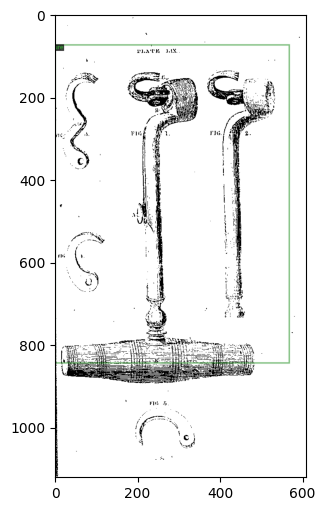

000170010401740.png


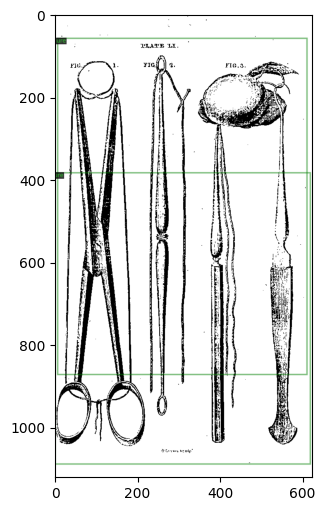

000170010402590.png


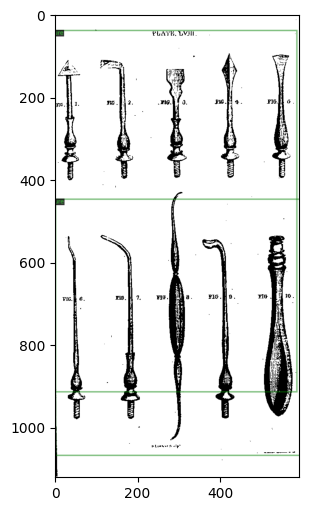

000170010402520.png


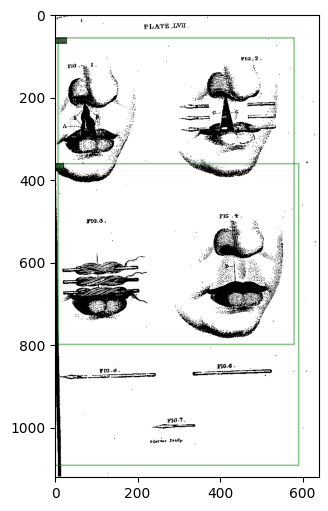

000170010403220.png


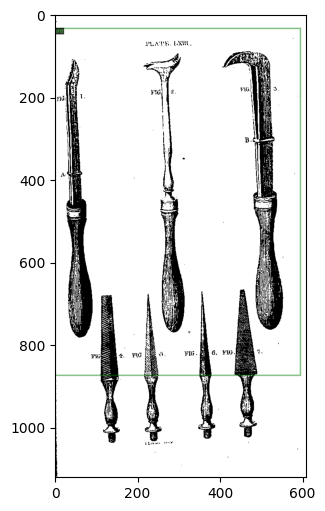

In [35]:

imagedir = "/scratch/project_2005488/DHH23/Test"
imagelist = os.listdir(imagedir)
for imgname in imagelist:
    if imgname.endswith(".png") or imgname.endswith(".jpg") or imgname.endswith(".jpeg"):
        print(imgname)
        image_path = os.path.join(imagedir,imgname)
        drawBoxes(image_path, predictor)
#        on_image(image_path, predictor)